<a href="https://colab.research.google.com/github/Nancy-Shi/Complex_Networks/blob/main/062223_SIR_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import math as math
from math import log

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [5]:
def generate_degree_sequence(n, gamma, kmin):
    # Generate a random set from the power law distribution
    u = np.random.uniform(size=n)
    degrees = np.ceil((1.0 - u) ** (-1.0 / (gamma - 1.0)))

    # Adjust degrees based on the minimum and maximum degree values
    kmax = int(np.sqrt(n)) # max degree allowed is square root of n
    degrees = degrees[(degrees >= kmin) & (degrees <= kmax)].astype(int)

    # Truncate or pad the sequence to match the length specified
    if len(degrees) >= n:
        degrees = degrees[:n]
    else:
        degrees = np.concatenate((degrees, np.full(n - len(degrees), kmin)))

    return degrees.tolist()

In [6]:
def generate_configuration_model(degree_sequence):
    # Create an empty graph and sum up the degrees
    G = nx.Graph()
    degree_sum = sum(degree_sequence)

    # Print error message if the sum is odd
    if degree_sum % 2 != 0:
        raise ValueError("Degree sum is odd")

    # Create a list of nodes based on the degree sequence
    nodes = []
    for node, degree in enumerate(degree_sequence):
        nodes.extend([node] * degree)

    # Shuffle the nodes list
    random.shuffle(nodes)

    # Track visited edges
    existing_edges = set()

    # Pair the nodes and add edges to the graph
    for i in range(0, len(nodes), 2):
        node1 = nodes[i]
        node2 = nodes[i + 1]

        # Check for self-edges and duplicate edges
        if node1 != node2 and (node1, node2) not in existing_edges:
            G.add_edge(node1, node2)
            existing_edges.add((node1, node2))
            existing_edges.add((node2, node1))

    return G

In [15]:
def OGA_SIR(network, lambda_, mu, t_end, initial_infected):
    """
    SIR model on a network with the Gillespie algorithm.

    Parameters:
        network : Network graph with node and degree information
        lambda_ : Infection rate
        mu : Recovery rate
        t_end : End time of the simulation
        initial_infected : Initial fraction of infected individuals

    Returns:
        t : Time points
        rho_S : Fraction of susceptible individuals
        rho_I : Fraction of infected individuals
        rho_R : Fraction of recovered individuals
        avg_rho_R : Average rho_R
        avg_t_max : Average epidemic die-out time
    """
    N = len(network.nodes)
    t = [0.0]
    rho_S = [1.0 - initial_infected]
    rho_I = [initial_infected]
    rho_R = [0.0]

    rho_R_sum = 0.0  # Variable to accumulate rho_R values
    t_max_sum = 0.0  # Variable to accumulate t_max values
    num_samples = 0  # Number of simulation samples

    while t[-1] < t_end:
        S = rho_S[-1]
        I = rho_I[-1]
        R = rho_R[-1]
        N_inf = int(round(I * N))
        N_e = 0

        # Calculate the number of links connected to infected nodes
        infected_nodes = np.random.choice(N, size=N_inf, replace=False)
        for node in infected_nodes:
            N_e += network.degree[node]

        # Calculate the healing probability p
        p = (mu * N_inf) / (mu * N_inf + lambda_ * N_e)

        # Calculate the time increment
        tau = -np.log(np.random.uniform(1e-6, 1)) / (mu * N_inf + lambda_ * N_e)
        t_new = t[-1] + tau

        if t_new > t_end:
            t_new = t_end

        # Update the fractions of susceptible, infected, and recovered individuals
        rho_S.append(S * np.exp(-mu * (t_new - t[-1])))
        rho_I.append(I * np.exp(-mu * (t_new - t[-1])))

        # Check if an infected individual gets healed
        if np.random.uniform() < p:
            rho_R.append(R + I * (1 - np.exp(-mu * (t_new - t[-1]))))
        else:
            # Check if there are any infected nodes
            if len(infected_nodes) > 0:
            # Randomly choose a neighbor
                neighbor = np.random.choice(list(network.neighbors(np.random.choice(infected_nodes))))

                if neighbor not in infected_nodes:
                # Infect the chosen neighbor if it is susceptible
                    rho_I[-1] += 1 / N
            else:
                # Randomly select a susceptible node to restart the infection
                susceptible_nodes = np.where(rho_S[-1] > 0)[0]
                restart_node = np.random.choice(susceptible_nodes)
                rho_I[-1] = 1 / N

        t.append(t_new)

        # Calculate and accumulate rho_R at each time step
        rho_R_sum += rho_R[-1]

        # Check for epidemic die-out
        if I == 0:
            t_max_sum += t_new
            num_samples += 1

    # Calculate the number of samples
    num_samples = len(t) - 1

    # Calculate the average values
    avg_rho_R = rho_R_sum / num_samples
    avg_t_max = t_max_sum / num_samples

    return np.array(t), np.array(rho_S), np.array(rho_I), np.array(rho_R), avg_rho_R, avg_t_max

[3, 4, 3, 3, 3, 4, 4, 4, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 5, 4, 5, 3, 3, 3, 12, 3, 3, 5, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 16, 3, 6, 3, 3, 4, 3, 3, 3, 10, 3, 4, 3, 3, 3, 3, 3, 5, 4, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 5, 4, 3, 4, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

<ipython-input-15-05ca61a35e94>:43: RuntimeWarning: invalid value encountered in double_scalars
  p = (mu * N_inf) / (mu * N_inf + lambda_ * N_e)
<ipython-input-15-05ca61a35e94>:46: RuntimeWarning: divide by zero encountered in double_scalars
  tau = -np.log(np.random.uniform(1e-6, 1)) / (mu * N_inf + lambda_ * N_e)


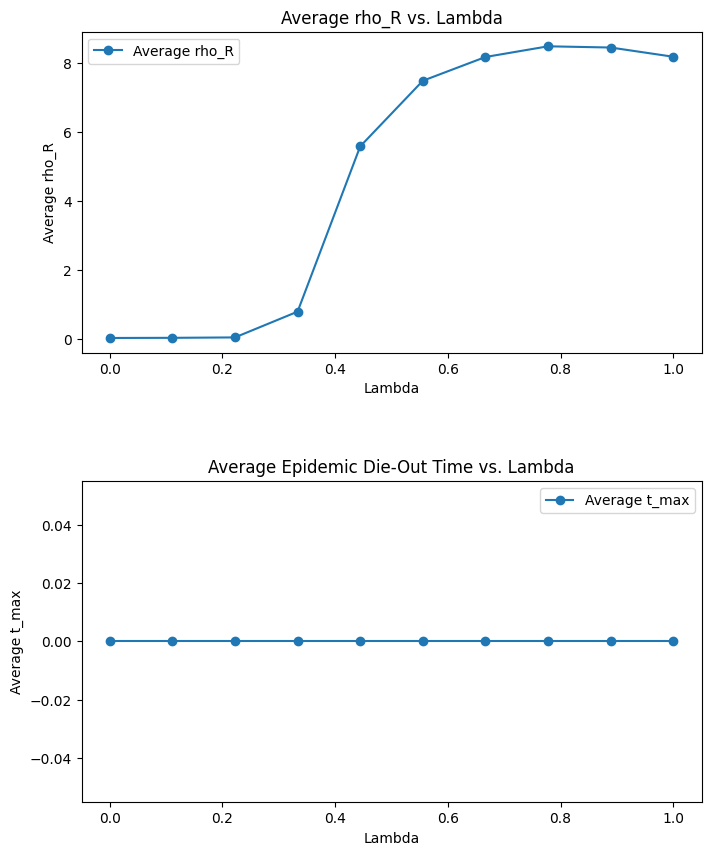

In [23]:
# Simulation parameters
lambda_values = np.linspace(0.01, 1.0, num=20)  # Range of infection rates
mu = 1  # Recovery rate
t_end = 100  # End time of the simulation
initial_infected = 0.05  # Initial fraction of infected individuals
n_samples = 10  # Number of simulation samples

# Create a network (Example: configuration model random graph)
n= 1000
gamma = 4.0
kmin = 3
degrees = generate_degree_sequence(n, gamma, kmin)
print(degrees)
network = generate_configuration_model(degrees)


# set information for the plot
lambda_values = np.linspace(0, 1, num=10)
# Empty lists to store average values for each lambda
avg_rho_R_values = []
avg_t_max_values = []

# Loop over lambda values
for lambda_ in lambda_values:
    # Run the SIR simulation
    t, rho_S, rho_I, rho_R, avg_rho_R, avg_t_max = OGA_SIR(network, lambda_, mu, t_end, initial_infected)

    # Append average values to the lists
    avg_rho_R_values.append(avg_rho_R)
    avg_t_max_values.append(avg_t_max)

# Convert the lists to numpy arrays
avg_rho_R_values = np.array(avg_rho_R_values)
avg_t_max_values = np.array(avg_t_max_values)

# Plot the two-panel graph
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Top panel: average rho_R against lambda
ax1.plot(lambda_values, avg_rho_R_values, 'o-', label='Average rho_R')
ax1.set_xlabel('Lambda')
ax1.set_ylabel('Average rho_R')
ax1.set_title('Average rho_R vs. Lambda')
ax1.legend()

# Bottom panel: average epidemic die-out time t_max against lambda
ax2.plot(lambda_values, avg_t_max_values, 'o-', label='Average t_max')
ax2.set_xlabel('Lambda')
ax2.set_ylabel('Average t_max')
ax2.set_title('Average Epidemic Die-Out Time vs. Lambda')
ax2.legend()

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)

# Display the graph
plt.show()